In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split

import os
import re
import json
import time
import random
import numpy as np
from collections import OrderedDict
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix, f1_score, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.preprocessing import OneHotEncoder

from IPython.display import Image

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
seed = 42

## Common parameters

In [14]:
batch_size = 8
# Percentage of training data
learning_rate = 0.001

device = "cuda"

# Loading bAbi

In [15]:
from babi import babiDataset
babi = babiDataset()
babi.load(verbose=True)
train_loader, valid_loader, test_loader = babi.create_data_loader(batch_size)

Training data size:    8000
Validation data size:  2000
Test data size:        1000


# LSTM

In [16]:
# Input dim
input_dim = babi.max_vocab_size
# Number of hidden nodes
hidden_dim = 256
# Number of output nodes
output_dim = babi.max_vocab_size
# Number of LSTMs cells to be stacked
layers = 1
# Boolean value for bidirectioanl or not
bidirectional = True
# Boolean value to use LayerNorm or not
layernorm = False

### Our implementation

In [46]:
from seq_seq_same import LSTMSeq2SeqSame

our = LSTMSeq2SeqSame(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, 
                        layers=layers, bidirectional=bidirectional).to(device)

print("Our implementation\n{}".format("=" * len("Our implementation")))
print("# of parameters: {}".format(our.count_parameters()))
for name, param in our.named_parameters():
    print("{:<25}: {}".format(name, param.shape))

Our implementation
# of parameters: 582678
lstm.model.0.weights     : torch.Size([278, 1024])
lstm.model.0.bias        : torch.Size([1024])
lstm.model_rev.0.weights : torch.Size([278, 1024])
lstm.model_rev.0.bias    : torch.Size([1024])
fc.weight                : torch.Size([22, 512])
fc.bias                  : torch.Size([22])


In [47]:
# from seq_seq_same import Seq2SeqSame

loss_fn = nn.CrossEntropyLoss()
optimizer_our = torch.optim.Adam(our.parameters(), lr=learning_rate)

task_our = Seq2SeqSame(our, optimizer_our, loss_fn, device)

Beginning training model with 582678 parameters
Files will be saved in: dump/Seq2SeqSame/Our/

Epoch #1: Batch 250/250 -- Loss = 2.2028255462646484; Time taken: 0.20014142990112305s
Epoch #1: Average loss is 2.240678891181946
Epoch #1: Validation Accuracy is 0.0
Epoch #1: Train Accuracy is 0.0
Time taken for epoch: 77.38060593605042s

Epoch #2: Batch 250/250 -- Loss = 2.202115058898926; Time taken: 0.23061871528625488ss
Epoch #2: Average loss is 2.2004033794403077
Time taken for epoch: 55.0276882648468s

Epoch #3: Batch 250/250 -- Loss = 2.1992738246917725; Time taken: 0.282886266708374sss
Epoch #3: Average loss is 2.2004031734466554
Time taken for epoch: 62.39732313156128s

Epoch #4: Batch 250/250 -- Loss = 2.2014036178588867; Time taken: 0.2220139503479004ss
Epoch #4: Average loss is 2.2004026832580568
Time taken for epoch: 64.567312002182s

Epoch #5: Batch 250/250 -- Loss = 2.1996278762817383; Time taken: 0.21903228759765625s
Epoch #5: Average loss is 2.200402070045471
Epoch #5: Val

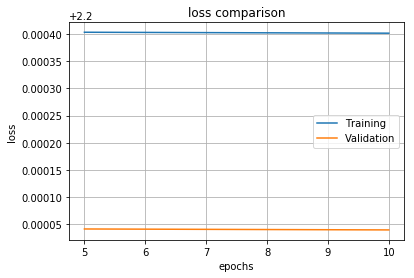

In [48]:
our, our_stats = task_our.train(epochs=6, train_loader=train_loader, valid_loader=valid_loader, 
                                            out_dir='dump/Seq2SeqSame/Our/', freq=5)

In [9]:
our_accuracy, _ = task_our.evaluate(test_loader, verbose=True)

NameError: name 'task_our' is not defined

### PyTorch implementation

In [17]:
from seq_seq_same import PyTorchBaseline

bidirectional = False

pytorch = PyTorchBaseline(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, 
                        layers=layers, bidirectional=bidirectional).to(device)

print("PyTorch implementation\n{}".format("=" * len("PyTorch implementation")))
print("# of parameters: {}".format(pytorch.count_parameters()))
for name, param in pytorch.named_parameters():
    print("{:<25}: {}".format(name, param.shape))

PyTorch implementation
# of parameters: 292374
lstm.weight_ih_l0        : torch.Size([1024, 22])
lstm.weight_hh_l0        : torch.Size([1024, 256])
lstm.bias_ih_l0          : torch.Size([1024])
lstm.bias_hh_l0          : torch.Size([1024])
fc.weight                : torch.Size([22, 256])
fc.bias                  : torch.Size([22])


In [18]:
from seq_seq_same import Seq2SeqSame

loss_fn = nn.CrossEntropyLoss()
optimizer_pytorch = torch.optim.Adam(pytorch.parameters(), lr=learning_rate)

task_pytorch = Seq2SeqSame(pytorch, optimizer_pytorch, loss_fn, device)

Beginning training model with 292374 parameters
Files will be saved in: dump/Seq2SeqSame/PyTorch/

Epoch #1: Batch 1000/1000 -- Loss = 2.2046613693237305; Time taken: 0.016531705856323242s
Epoch #1: Average loss is 2.215294578552246
Epoch #1: Validation Accuracy is 0.0
Epoch #1: Train Accuracy is 0.0
Time taken for epoch: 26.177875518798828s

Epoch #2: Batch 1000/1000 -- Loss = 2.2046096324920654; Time taken: 0.01647639274597168s
Epoch #2: Average loss is 2.2002961082458494
Time taken for epoch: 17.44357204437256s

Epoch #3: Batch 1000/1000 -- Loss = 2.1960792541503906; Time taken: 0.016546249389648438s
Epoch #3: Average loss is 2.200275460720062
Time taken for epoch: 17.410171031951904s

Epoch #4: Batch 1000/1000 -- Loss = 2.2117016315460205; Time taken: 0.016537904739379883s
Epoch #4: Average loss is 2.2002709653377535
Time taken for epoch: 17.494926929473877s

Epoch #5: Batch 1000/1000 -- Loss = 2.2031779289245605; Time taken: 0.01650214195251465s
Epoch #5: Average loss is 2.2002692

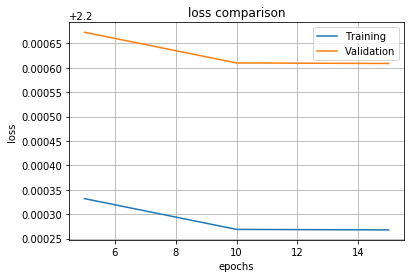

In [19]:
pytorch, pytorch_stats = task_pytorch.train(epochs=10, train_loader=train_loader, valid_loader=valid_loader, 
                                            out_dir='dump/Seq2SeqSame/PyTorch/', freq=5)

In [10]:
pytorch_accuracy, _ = task_pytorch.evaluate(test_loader, verbose=True)

Confusion Matrix: 
 [[  0   0   0   0   0   0   0]
 [461   0   0   0   0   0   0]
 [441   0   0   0   0   0   0]
 [607   0   0   0   0   0   0]
 [527   0   0   0   0   0   0]
 [497   0   0   0   0   0   0]
 [467   0   0   0   0   0   0]]
Classification Report: 
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           7       0.00      0.00      0.00       461
          10       0.00      0.00      0.00       441
          16       0.00      0.00      0.00       607
          17       0.00      0.00      0.00       527
          20       0.00      0.00      0.00       497
          21       0.00      0.00      0.00       467

   micro avg       0.00      0.00      0.00      3000
   macro avg       0.00      0.00      0.00      3000
weighted avg       0.00      0.00      0.00      3000



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


***

# TRANSFORMER